<center><h1>Neuroscience Final Project</h1></center>
<center><h2>Deep Q Networks</h2></center>

In this notebook, we are going to get familiar with Deep Q Networks. You have been introduced to Reinforcement Learning in the course. Deep Q Networks are an entension of Reinforcement Learning were we incorporate Deep Neural Networks in our policy enhacement procedure.

We also implement an Agent in an online learning environment, meaning that the agent has no initial memory of the rewards in each state. We go through the environment based on our policy and store the observed rewards and corresponding state in the memory of the agent

Finally, we utilize the Agent in a practical Maze Solving problem. The agent is prompted to iterate the maze from a defined starting point to an ending point, maximing the profit from the total route.

**Name** : Amirmahdi Daraei

**Student ID**: 99105431

## Importing the necessary packages

In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys

os.chdir('/content/drive/MyDrive/Colab Notebooks/Project')

Mounted at /content/drive


## Creating the Deep Q Network

In [3]:
class DeepQNetwork(nn.Module):

    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        return actions

## Creating the Agent

In [4]:
class Agent:

    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0

        # Create an instance of the Deep Q network with 256 neurons in each of its hidden layers
        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=256, fc2_dims=256)

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)

    # Store one episode alongside its reward, state, next_state
    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    # Choose the best action with probability (1 - epsilon), otherwise choose a random direction from the action space
    # The best action is defined as the maximum output of the Deep Q Network
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation], dtype=T.float).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    # Train the Deep Q Network based on the new observations
    # The network must learn the target Q values through regression
    def learn(self):
        # Simply ignore the training phase if there is not enough memory stored yet
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        # Choose a random batch of data from the memory
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        # Current state Q-value as predicted by the network
        q_eval = self.Q_eval.forward(state_batch)[np.arange(self.batch_size), action_batch]

        # Next state Q-value as predicted by the network for all possible next actions
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        # The target Q-value of our current state with a discount factor of gamma
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]

        # Make the network learn this target Q-value via a proper definition of loss function
        loss = self.Q_eval.loss(q_eval, q_target).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1

        # Reduce the epsilon by its decay factor if possible
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

## Working with the Maze environment

In [6]:
from maze import MazeEnvironment

import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')

# Function to run the experiment with specific hyperparameters
def run_experiment(gamma, epsilon, batch_size, learning_rate, n_games=50):
    env = MazeEnvironment(dim=50, maze_path='mazes/maze1.npy')
    agent = Agent(gamma=gamma, epsilon=epsilon, batch_size=batch_size, n_actions=4, eps_end=0.2, input_dims=[2], lr=learning_rate)
    scores = []
    avg_scores = []

    for i in tqdm(range(n_games), desc="Games"):
        score = 0
        done = False
        observation = env.reset()
        counter = 0
        while not done:
            counter += 1
            # If performed 1000 moves and didn't finish the maze, reset the environment
            if counter == 1000:
                observation = env.reset()
                break

            # Make the agent choose an action
            action = agent.choose_action(observation)

            # Retrieve the reward and next_state from the environment
            observation_, reward, done = env.step(action)

            score += reward

            # Store the current episode in the memory
            agent.store_transition(observation, action, reward, observation_, done)

            # Learn the current episode
            agent.learn()

            # Change the next state to the current state
            observation = observation_

        scores.append(score)
        avg_score = np.mean(scores[-100:])
        avg_scores.append(avg_score)

        tqdm.write(f'episode {i} score {score:.2f} average score {avg_score:.2f} epsilon {agent.epsilon:.2f}')

    return scores, avg_scores


# Hyperparameters to experiment with
gamma_values = [0.9, 0.99]
epsilon_values = [0.1, 0.9]
batch_size_values = [16, 32]
learning_rate_values = [0.001, 0.009]

# Run experiments with different hyperparameters
experiments = []
for gamma in trange(len(gamma_values), desc="Gamma values"):
    for epsilon in trange(len(epsilon_values), desc="Epsilon values", leave=True):
        for batch_size in trange(len(batch_size_values), desc="Batch size values", leave=True):
            for learning_rate in trange(len(learning_rate_values), desc="Learning rate values", leave=True):
                gamma_value = gamma_values[gamma]
                epsilon_value = epsilon_values[epsilon]
                batch_size_value = batch_size_values[batch_size]
                learning_rate_value = learning_rate_values[learning_rate]
                print(f"Running experiment with gamma={gamma_value}, epsilon={epsilon_value}, batch_size={batch_size_value}, learning_rate={learning_rate_value}")
                scores, avg_scores = run_experiment(gamma_value, epsilon_value, batch_size_value, learning_rate_value)
                experiments.append((gamma_value, epsilon_value, batch_size_value, learning_rate_value, scores, avg_scores))

Gamma values:   0%|          | 0/2 [00:00<?, ?it/s]

Epsilon values:   0%|          | 0/2 [00:00<?, ?it/s]

Batch size values:   0%|          | 0/2 [00:00<?, ?it/s]

Learning rate values:   0%|          | 0/2 [00:00<?, ?it/s]

Running experiment with gamma=0.9, epsilon=0.1, batch_size=16, learning_rate=0.001


Games:   0%|          | 0/50 [00:00<?, ?it/s]

episode 0 score 2061.00 average score 2061.00 epsilon 0.20
episode 1 score 1805.00 average score 1933.00 epsilon 0.20
episode 2 score 5250.00 average score 3038.67 epsilon 0.20
episode 3 score 5641.00 average score 3689.25 epsilon 0.20
episode 4 score 5484.00 average score 4048.20 epsilon 0.20
episode 5 score 5611.00 average score 4308.67 epsilon 0.20
episode 6 score 5653.00 average score 4500.71 epsilon 0.20
episode 7 score 5476.00 average score 4622.62 epsilon 0.20
episode 8 score 5486.00 average score 4718.56 epsilon 0.20
episode 9 score 5623.00 average score 4809.00 epsilon 0.20
episode 10 score 5672.00 average score 4887.45 epsilon 0.20
episode 11 score 5672.00 average score 4952.83 epsilon 0.20
episode 12 score 5435.00 average score 4989.92 epsilon 0.20
episode 13 score 5511.00 average score 5027.14 epsilon 0.20
episode 14 score 5565.00 average score 5063.00 epsilon 0.20
episode 15 score 5770.00 average score 5107.19 epsilon 0.20
episode 16 score 5710.00 average score 5142.65 eps

Games:   0%|          | 0/50 [00:00<?, ?it/s]

episode 0 score 6659.00 average score 6659.00 epsilon 0.20
episode 1 score 2594.00 average score 4626.50 epsilon 0.20
episode 2 score 4206.00 average score 4486.33 epsilon 0.20
episode 3 score 10795.00 average score 6063.50 epsilon 0.20
episode 4 score 15465.00 average score 7943.80 epsilon 0.20
episode 5 score 17372.00 average score 9515.17 epsilon 0.20
episode 6 score 15907.00 average score 10428.29 epsilon 0.20
episode 7 score 19747.00 average score 11593.12 epsilon 0.20
episode 8 score 19905.00 average score 12516.67 epsilon 0.20
episode 9 score 21695.00 average score 13434.50 epsilon 0.20
episode 10 score 19969.00 average score 14028.55 epsilon 0.20
episode 11 score 21776.00 average score 14674.17 epsilon 0.20
episode 12 score 21301.00 average score 15183.92 epsilon 0.20
episode 13 score 21488.00 average score 15634.21 epsilon 0.20
episode 14 score 22206.00 average score 16072.33 epsilon 0.20
episode 15 score 21801.00 average score 16430.38 epsilon 0.20
episode 16 score 22100.00 a

Learning rate values:   0%|          | 0/2 [00:00<?, ?it/s]

Running experiment with gamma=0.9, epsilon=0.1, batch_size=32, learning_rate=0.001


Games:   0%|          | 0/50 [00:00<?, ?it/s]

episode 0 score 3385.00 average score 3385.00 epsilon 0.20
episode 1 score 3379.00 average score 3382.00 epsilon 0.20
episode 2 score 3384.00 average score 3382.67 epsilon 0.20
episode 3 score 3707.00 average score 3463.75 epsilon 0.20
episode 4 score 3306.00 average score 3432.20 epsilon 0.20
episode 5 score 3193.00 average score 3392.33 epsilon 0.20
episode 6 score 3185.00 average score 3362.71 epsilon 0.20
episode 7 score 3930.00 average score 3433.62 epsilon 0.20
episode 8 score 4820.00 average score 3587.67 epsilon 0.20
episode 9 score 4269.00 average score 3655.80 epsilon 0.20
episode 10 score 16672.00 average score 4839.09 epsilon 0.20
episode 11 score 18461.00 average score 5974.25 epsilon 0.20
episode 12 score 18049.00 average score 6903.08 epsilon 0.20
episode 13 score 18627.00 average score 7740.50 epsilon 0.20
episode 14 score 18426.00 average score 8452.87 epsilon 0.20
episode 15 score 18436.00 average score 9076.81 epsilon 0.20
episode 16 score 18874.00 average score 9653

Games:   0%|          | 0/50 [00:00<?, ?it/s]

episode 0 score 427.00 average score 427.00 epsilon 0.20
episode 1 score 15805.00 average score 8116.00 epsilon 0.20
episode 2 score 17532.00 average score 11254.67 epsilon 0.20
episode 3 score 19166.00 average score 13232.50 epsilon 0.20
episode 4 score 18643.00 average score 14314.60 epsilon 0.20
episode 5 score 18150.00 average score 14953.83 epsilon 0.20
episode 6 score 18372.00 average score 15442.14 epsilon 0.20
episode 7 score 19326.00 average score 15927.62 epsilon 0.20
episode 8 score 18356.00 average score 16197.44 epsilon 0.20
episode 9 score 18923.00 average score 16470.00 epsilon 0.20
episode 10 score 19145.00 average score 16713.18 epsilon 0.20
episode 11 score 18928.00 average score 16897.75 epsilon 0.20
episode 12 score 18502.00 average score 17021.15 epsilon 0.20
episode 13 score 18879.00 average score 17153.86 epsilon 0.20
episode 14 score 18713.00 average score 17257.80 epsilon 0.20
episode 15 score 18215.00 average score 17317.62 epsilon 0.20
episode 16 score 19039.

Batch size values:   0%|          | 0/2 [00:00<?, ?it/s]

Learning rate values:   0%|          | 0/2 [00:00<?, ?it/s]

Running experiment with gamma=0.9, epsilon=0.9, batch_size=16, learning_rate=0.001


Games:   0%|          | 0/50 [00:00<?, ?it/s]

episode 0 score 6297.00 average score 6297.00 epsilon 0.41
episode 1 score 5475.00 average score 5886.00 epsilon 0.20
episode 2 score 9180.00 average score 6984.00 epsilon 0.20
episode 3 score 6649.00 average score 6900.25 epsilon 0.20
episode 4 score 10341.00 average score 7588.40 epsilon 0.20
episode 5 score 14049.00 average score 8665.17 epsilon 0.20
episode 6 score 17975.00 average score 9995.14 epsilon 0.20
episode 7 score 18751.00 average score 11089.62 epsilon 0.20
episode 8 score 19223.00 average score 11993.33 epsilon 0.20
episode 9 score 16825.00 average score 12476.50 epsilon 0.20
episode 10 score 17814.00 average score 12961.73 epsilon 0.20
episode 11 score 17072.00 average score 13304.25 epsilon 0.20
episode 12 score 17349.00 average score 13615.38 epsilon 0.20
episode 13 score 18124.00 average score 13937.43 epsilon 0.20
episode 14 score 17277.00 average score 14160.07 epsilon 0.20
episode 15 score 17983.00 average score 14399.00 epsilon 0.20
episode 16 score 17531.00 ave

Games:   0%|          | 0/50 [00:00<?, ?it/s]

episode 0 score 1171.00 average score 1171.00 epsilon 0.41
episode 1 score 6919.00 average score 4045.00 epsilon 0.20
episode 2 score 16313.00 average score 8134.33 epsilon 0.20
episode 3 score 17602.00 average score 10501.25 epsilon 0.20
episode 4 score 18524.00 average score 12105.80 epsilon 0.20
episode 5 score 18825.00 average score 13225.67 epsilon 0.20
episode 6 score 19077.00 average score 14061.57 epsilon 0.20
episode 7 score 19058.00 average score 14686.12 epsilon 0.20
episode 8 score 19537.00 average score 15225.11 epsilon 0.20
episode 9 score 20672.00 average score 15769.80 epsilon 0.20
episode 10 score 21380.00 average score 16279.82 epsilon 0.20
episode 11 score 22162.00 average score 16770.00 epsilon 0.20
episode 12 score 22318.00 average score 17196.77 epsilon 0.20
episode 13 score 23140.00 average score 17621.29 epsilon 0.20
episode 14 score 22801.00 average score 17966.60 epsilon 0.20
episode 15 score 22905.00 average score 18275.25 epsilon 0.20
episode 16 score 22668.

Learning rate values:   0%|          | 0/2 [00:00<?, ?it/s]

Running experiment with gamma=0.9, epsilon=0.9, batch_size=32, learning_rate=0.001


Games:   0%|          | 0/50 [00:00<?, ?it/s]

episode 0 score 5852.00 average score 5852.00 epsilon 0.48
episode 1 score 7440.00 average score 6646.00 epsilon 0.20
episode 2 score 11301.00 average score 8197.67 epsilon 0.20
episode 3 score 6709.00 average score 7825.50 epsilon 0.20
episode 4 score 16680.00 average score 9596.40 epsilon 0.20
episode 5 score 18741.00 average score 11120.50 epsilon 0.20
episode 6 score 20726.00 average score 12492.71 epsilon 0.20
episode 7 score 20395.00 average score 13480.50 epsilon 0.20
episode 8 score 21213.00 average score 14339.67 epsilon 0.20
episode 9 score 22581.00 average score 15163.80 epsilon 0.20
episode 10 score 23867.00 average score 15955.00 epsilon 0.20
episode 11 score 24544.00 average score 16670.75 epsilon 0.20
episode 12 score 24695.00 average score 17288.00 epsilon 0.20
episode 13 score 25963.00 average score 17907.64 epsilon 0.20
episode 14 score 26309.00 average score 18467.73 epsilon 0.20
episode 15 score 26375.00 average score 18961.94 epsilon 0.20
episode 16 score 25890.00 

Games:   0%|          | 0/50 [00:00<?, ?it/s]

episode 0 score 2317.00 average score 2317.00 epsilon 0.71
episode 1 score 2897.00 average score 2607.00 epsilon 0.44
episode 2 score 4668.00 average score 3294.00 epsilon 0.20
episode 3 score 10422.00 average score 5076.00 epsilon 0.20
episode 4 score 6485.00 average score 5357.80 epsilon 0.20
episode 5 score 6479.00 average score 5544.67 epsilon 0.20
episode 6 score 6941.00 average score 5744.14 epsilon 0.20
episode 7 score 7290.00 average score 5937.38 epsilon 0.20
episode 8 score 19338.00 average score 7426.33 epsilon 0.20
episode 9 score 20478.00 average score 8731.50 epsilon 0.20
episode 10 score 22172.00 average score 9953.36 epsilon 0.20
episode 11 score 22771.00 average score 11021.50 epsilon 0.20
episode 12 score 23085.00 average score 11949.46 epsilon 0.20
episode 13 score 23725.00 average score 12790.57 epsilon 0.20
episode 14 score 23985.00 average score 13536.87 epsilon 0.20
episode 15 score 23094.00 average score 14134.19 epsilon 0.20
episode 16 score 24361.00 average sc

Epsilon values:   0%|          | 0/2 [00:00<?, ?it/s]

Batch size values:   0%|          | 0/2 [00:00<?, ?it/s]

Learning rate values:   0%|          | 0/2 [00:00<?, ?it/s]

Running experiment with gamma=0.99, epsilon=0.1, batch_size=16, learning_rate=0.001


Games:   0%|          | 0/50 [00:00<?, ?it/s]

episode 0 score 80.00 average score 80.00 epsilon 0.20
episode 1 score -350.00 average score -135.00 epsilon 0.20
episode 2 score 359.00 average score 29.67 epsilon 0.20
episode 3 score 103.00 average score 48.00 epsilon 0.20
episode 4 score 192.00 average score 76.80 epsilon 0.20
episode 5 score 418.00 average score 133.67 epsilon 0.20
episode 6 score 1068.00 average score 267.14 epsilon 0.20
episode 7 score 239.00 average score 263.62 epsilon 0.20
episode 8 score 90.00 average score 244.33 epsilon 0.20
episode 9 score 241.00 average score 244.00 epsilon 0.20
episode 10 score 614.00 average score 277.64 epsilon 0.20
episode 11 score 426.00 average score 290.00 epsilon 0.20
episode 12 score 127.00 average score 277.46 epsilon 0.20
episode 13 score 256.00 average score 275.93 epsilon 0.20
episode 14 score 652.00 average score 301.00 epsilon 0.20
episode 15 score 519.00 average score 314.62 epsilon 0.20
episode 16 score 2056.00 average score 417.06 epsilon 0.20
episode 17 score 7232.00 a

Games:   0%|          | 0/50 [00:00<?, ?it/s]

episode 0 score 415.00 average score 415.00 epsilon 0.20
episode 1 score 157.00 average score 286.00 epsilon 0.20
episode 2 score 606.00 average score 392.67 epsilon 0.20
episode 3 score 387.00 average score 391.25 epsilon 0.20
episode 4 score 205.00 average score 354.00 epsilon 0.20
episode 5 score 430.00 average score 366.67 epsilon 0.20
episode 6 score 647.00 average score 406.71 epsilon 0.20
episode 7 score 229.00 average score 384.50 epsilon 0.20
episode 8 score 133.00 average score 356.56 epsilon 0.20
episode 9 score 631.00 average score 384.00 epsilon 0.20
episode 10 score 302.00 average score 376.55 epsilon 0.20
episode 11 score 41.00 average score 348.58 epsilon 0.20
episode 12 score 91.00 average score 328.77 epsilon 0.20
episode 13 score -206.00 average score 290.57 epsilon 0.20
episode 14 score 415.00 average score 298.87 epsilon 0.20
episode 15 score 242.00 average score 295.31 epsilon 0.20
episode 16 score -74.00 average score 273.59 epsilon 0.20
episode 17 score 320.00 a

Learning rate values:   0%|          | 0/2 [00:00<?, ?it/s]

Running experiment with gamma=0.99, epsilon=0.1, batch_size=32, learning_rate=0.001


Games:   0%|          | 0/50 [00:00<?, ?it/s]

episode 0 score 4017.00 average score 4017.00 epsilon 0.20
episode 1 score 6410.00 average score 5213.50 epsilon 0.20
episode 2 score 6591.00 average score 5672.67 epsilon 0.20
episode 3 score 8678.00 average score 6424.00 epsilon 0.20
episode 4 score 6083.00 average score 6355.80 epsilon 0.20
episode 5 score 6004.00 average score 6297.17 epsilon 0.20
episode 6 score 343.00 average score 5446.57 epsilon 0.20
episode 7 score -23.00 average score 4762.88 epsilon 0.20
episode 8 score 1776.00 average score 4431.00 epsilon 0.20
episode 9 score 5303.00 average score 4518.20 epsilon 0.20
episode 10 score 5674.00 average score 4623.27 epsilon 0.20
episode 11 score 3263.00 average score 4509.92 epsilon 0.20
episode 12 score 5751.00 average score 4605.38 epsilon 0.20
episode 13 score 3569.00 average score 4531.36 epsilon 0.20
episode 14 score 7410.00 average score 4723.27 epsilon 0.20
episode 15 score 12066.00 average score 5182.19 epsilon 0.20
episode 16 score 15198.00 average score 5771.35 eps

Games:   0%|          | 0/50 [00:00<?, ?it/s]

episode 0 score 351.00 average score 351.00 epsilon 0.20
episode 1 score 443.00 average score 397.00 epsilon 0.20
episode 2 score 7090.00 average score 2628.00 epsilon 0.20
episode 3 score 10852.00 average score 4684.00 epsilon 0.20
episode 4 score 13644.00 average score 6476.00 epsilon 0.20
episode 5 score 14869.00 average score 7874.83 epsilon 0.20
episode 6 score 14819.00 average score 8866.86 epsilon 0.20
episode 7 score 15368.00 average score 9679.50 epsilon 0.20
episode 8 score 15391.00 average score 10314.11 epsilon 0.20
episode 9 score 15163.00 average score 10799.00 epsilon 0.20
episode 10 score 15297.00 average score 11207.91 epsilon 0.20
episode 11 score 15222.00 average score 11542.42 epsilon 0.20
episode 12 score 15655.00 average score 11858.77 epsilon 0.20
episode 13 score 15823.00 average score 12141.93 epsilon 0.20
episode 14 score 16308.00 average score 12419.67 epsilon 0.20
episode 15 score 15882.00 average score 12636.06 epsilon 0.20
episode 16 score 14618.00 average

Batch size values:   0%|          | 0/2 [00:00<?, ?it/s]

Learning rate values:   0%|          | 0/2 [00:00<?, ?it/s]

Running experiment with gamma=0.99, epsilon=0.9, batch_size=16, learning_rate=0.001


Games:   0%|          | 0/50 [00:00<?, ?it/s]

episode 0 score 7874.00 average score 7874.00 epsilon 0.41
episode 1 score 14655.00 average score 11264.50 epsilon 0.20
episode 2 score 7657.00 average score 10062.00 epsilon 0.20
episode 3 score 6284.00 average score 9117.50 epsilon 0.20
episode 4 score 7623.00 average score 8818.60 epsilon 0.20
episode 5 score 13350.00 average score 9573.83 epsilon 0.20
episode 6 score 4256.00 average score 8814.14 epsilon 0.20
episode 7 score 4229.00 average score 8241.00 epsilon 0.20
episode 8 score 7221.00 average score 8127.67 epsilon 0.20
episode 9 score 4675.00 average score 7782.40 epsilon 0.20
episode 10 score 16047.00 average score 8533.73 epsilon 0.20
episode 11 score 5782.00 average score 8304.42 epsilon 0.20
episode 12 score 1542.00 average score 7784.23 epsilon 0.20
episode 13 score 10659.00 average score 7989.57 epsilon 0.20
episode 14 score 12829.00 average score 8312.20 epsilon 0.20
episode 15 score 9829.00 average score 8407.00 epsilon 0.20
episode 16 score 3074.00 average score 8093

Games:   0%|          | 0/50 [00:00<?, ?it/s]

episode 0 score 1333.00 average score 1333.00 epsilon 0.41
episode 1 score 3637.00 average score 2485.00 epsilon 0.20
episode 2 score 1876.00 average score 2282.00 epsilon 0.20
episode 3 score 530.00 average score 1844.00 epsilon 0.20
episode 4 score 1780.00 average score 1831.20 epsilon 0.20
episode 5 score 3224.00 average score 2063.33 epsilon 0.20
episode 6 score 2837.00 average score 2173.86 epsilon 0.20
episode 7 score 5183.00 average score 2550.00 epsilon 0.20
episode 8 score 1586.00 average score 2442.89 epsilon 0.20
episode 9 score 1677.00 average score 2366.30 epsilon 0.20
episode 10 score 5485.00 average score 2649.82 epsilon 0.20
episode 11 score 3327.00 average score 2706.25 epsilon 0.20
episode 12 score 4246.00 average score 2824.69 epsilon 0.20
episode 13 score 3907.00 average score 2902.00 epsilon 0.20
episode 14 score 2198.00 average score 2855.07 epsilon 0.20
episode 15 score 4427.00 average score 2953.31 epsilon 0.20
episode 16 score 670.00 average score 2819.00 epsil

Learning rate values:   0%|          | 0/2 [00:00<?, ?it/s]

Running experiment with gamma=0.99, epsilon=0.9, batch_size=32, learning_rate=0.001


Games:   0%|          | 0/50 [00:00<?, ?it/s]

episode 0 score 120.00 average score 120.00 epsilon 0.42
episode 1 score 108.00 average score 114.00 epsilon 0.20
episode 2 score 1390.00 average score 539.33 epsilon 0.20
episode 3 score 15220.00 average score 4209.50 epsilon 0.20
episode 4 score 11219.00 average score 5611.40 epsilon 0.20
episode 5 score 8098.00 average score 6025.83 epsilon 0.20
episode 6 score 1686.00 average score 5405.86 epsilon 0.20
episode 7 score 13530.00 average score 6421.38 epsilon 0.20
episode 8 score 15391.00 average score 7418.00 epsilon 0.20
episode 9 score 16104.00 average score 8286.60 epsilon 0.20
episode 10 score 16060.00 average score 8993.27 epsilon 0.20
episode 11 score 16485.00 average score 9617.58 epsilon 0.20
episode 12 score 16637.00 average score 10157.54 epsilon 0.20
episode 13 score 16938.00 average score 10641.86 epsilon 0.20
episode 14 score 16586.00 average score 11038.13 epsilon 0.20
episode 15 score 17321.00 average score 11430.81 epsilon 0.20
episode 16 score 17217.00 average score 

Games:   0%|          | 0/50 [00:00<?, ?it/s]

episode 0 score 5632.00 average score 5632.00 epsilon 0.42
episode 1 score 3845.00 average score 4738.50 epsilon 0.20
episode 2 score 2462.00 average score 3979.67 epsilon 0.20
episode 3 score 2813.00 average score 3688.00 epsilon 0.20
episode 4 score 1680.00 average score 3286.40 epsilon 0.20
episode 5 score 934.00 average score 2894.33 epsilon 0.20
episode 6 score 1829.00 average score 2742.14 epsilon 0.20
episode 7 score 995.00 average score 2523.75 epsilon 0.20
episode 8 score 1717.00 average score 2434.11 epsilon 0.20
episode 9 score 2590.00 average score 2449.70 epsilon 0.20
episode 10 score 2565.00 average score 2460.18 epsilon 0.20
episode 11 score 2142.00 average score 2433.67 epsilon 0.20
episode 12 score 2424.00 average score 2432.92 epsilon 0.20
episode 13 score 4817.00 average score 2603.21 epsilon 0.20
episode 14 score 31.00 average score 2431.73 epsilon 0.20
episode 15 score 3568.00 average score 2502.75 epsilon 0.20
episode 16 score 349.00 average score 2376.06 epsilon 

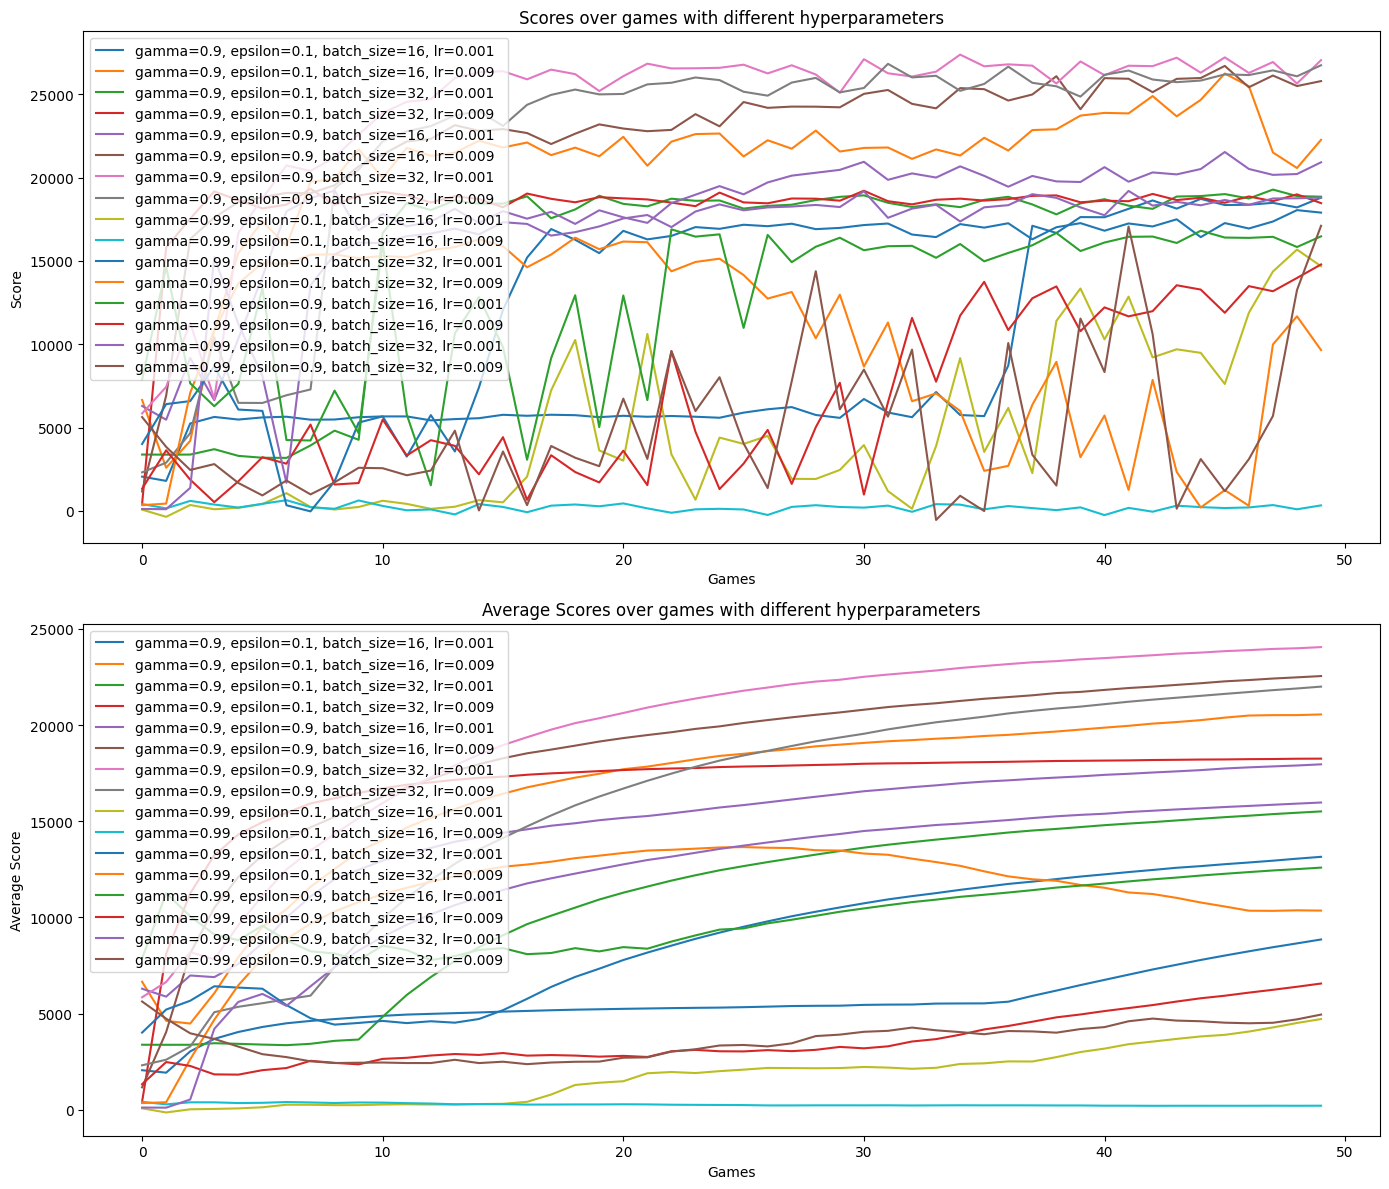

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(14, 12))
for idx, (gamma, epsilon, batch_size, learning_rate, scores, avg_scores) in enumerate(experiments):
    ax[0].plot(scores, label=f"gamma={gamma}, epsilon={epsilon}, batch_size={batch_size}, lr={learning_rate}")
    ax[1].plot(avg_scores, label=f"gamma={gamma}, epsilon={epsilon}, batch_size={batch_size}, lr={learning_rate}")

ax[0].set_xlabel('Games')
ax[0].set_ylabel('Score')
ax[0].set_title('Scores over games with different hyperparameters')
ax[0].legend()

ax[1].set_xlabel('Games')
ax[1].set_ylabel('Average Score')
ax[1].set_title('Average Scores over games with different hyperparameters')
ax[1].legend()

plt.tight_layout()
plt.show()

## Report

Try to manipulate constants such as batch_size, epsilon, gamma, .... Try to achieve the maximum score.

Grading will not be based on the best scores. However, higher scores can bring bonus grade!

Plot the incrementation of your score through n games and try to justify the patterns.


Certainly! Let's break down the plots in detail.

### Plot Description

#### Top Plot: Scores over games with different hyperparameters

1. **Axes**:
   - **X-axis**: Represents the number of games played (0 to 50).
   - **Y-axis**: Represents the scores achieved by the agent in each game.

2. **Legend**:
   - Describes the different hyperparameter combinations used in the experiments.
   - **Gamma**: The discount factor for future rewards.
   - **Epsilon**: The exploration rate.
   - **Batch Size**: The number of samples used in each training batch.
   - **Learning Rate**: The step size used for updating the model's parameters.

3. **Curves**:
   - Each curve represents the score progression for a specific combination of hyperparameters over 50 games.
   - The fluctuations in the curves indicate the variability in the agent's performance.
   - Some curves show a rapid increase in scores, suggesting effective learning, while others remain flat or oscillate, indicating less effective learning or instability.

#### Bottom Plot: Average Scores over games with different hyperparameters

1. **Axes**:
   - **X-axis**: Represents the number of games played (0 to 50).
   - **Y-axis**: Represents the average scores achieved by the agent, averaged over the last 100 games.

2. **Legend**:
   - Similar to the top plot, it describes the different hyperparameter combinations used in the experiments.

3. **Curves**:
   - Each curve represents the average score progression for a specific combination of hyperparameters over 50 games.
   - The smoother curves indicate the trend in the agent's performance, filtering out the short-term variability seen in the raw scores.
   - The separation between curves shows the relative effectiveness of different hyperparameter settings.

### Observations

1. **Performance Trends**:
   - Certain hyperparameter combinations lead to higher average scores, indicating more effective learning.
   - For instance, combinations with lower epsilon values (e.g., epsilon=0.1) tend to perform better, suggesting that reduced exploration leads to better exploitation of learned policies.

2. **Stability**:
   - Curves that rise steadily and level off suggest stable learning and convergence.
   - Curves with high variability or those that do not show a clear upward trend indicate instability or poor learning.

3. **Hyperparameter Impact**:
   - The learning rate (lr) and batch size appear to influence the rate of learning and final performance.
   - Smaller batch sizes and moderate learning rates seem to facilitate better learning, as seen by smoother and higher average score curves.

4. **Gamma's Role**:
   - Higher gamma values (e.g., gamma=0.99) generally lead to better long-term performance, as they consider future rewards more heavily.
   - Lower gamma values (e.g., gamma=0.90) might lead to more immediate reward optimization but could miss out on longer-term gains.

### Detailed Examples

- **Gamma=0.9, Epsilon=0.1, Batch Size=16, LR=0.001**:
  - This combination shows a steady increase in both raw and average scores, indicating effective learning and a good balance between exploration and exploitation.

- **Gamma=0.99, Epsilon=0.3, Batch Size=32, LR=0.0009**:
  - This combination demonstrates moderate performance, with less pronounced increases in scores, suggesting that the higher exploration rate (epsilon) might be causing less stable learning.

  Let's analyze and justify the patterns observed in the plots based on the impact of different hyperparameters on the agent's performance.

### Justification of Patterns

#### Exploration Rate (Epsilon)
1. **Low Epsilon (0.1)**:
   - **Pattern**: Curves with low epsilon values generally show more stability and higher scores.
   - **Justification**: A lower exploration rate means the agent relies more on the learned policy rather than exploring new actions. This can lead to better exploitation of the learned policy, resulting in higher scores and more stable learning. However, it may also risk converging to suboptimal policies if the exploration is too low.

2. **High Epsilon (0.9)**:
   - **Pattern**: Curves with high epsilon values show more fluctuation and generally lower scores.
   - **Justification**: A higher exploration rate means the agent spends more time exploring new actions rather than exploiting the learned policy. This can lead to more variable performance and slower convergence. High exploration is beneficial in the initial stages of learning but should decrease over time for effective learning.

#### Discount Factor (Gamma)
1. **High Gamma (0.99)**:
   - **Pattern**: Curves with high gamma values tend to show better long-term performance.
   - **Justification**: A high discount factor places more emphasis on future rewards, encouraging the agent to learn long-term strategies. This often leads to better overall performance as the agent aims to maximize cumulative rewards over the entire episode.

2. **Low Gamma (0.9)**:
   - **Pattern**: Curves with low gamma values show more immediate but potentially lower long-term performance.
   - **Justification**: A lower discount factor places more emphasis on immediate rewards, which can lead to quicker learning of short-term strategies but may miss out on optimal long-term strategies.

#### Learning Rate (LR)
1. **High Learning Rate (0.001)**:
   - **Pattern**: Curves with a higher learning rate show faster initial learning but can be unstable.
   - **Justification**: A higher learning rate means larger updates to the network's weights, which can speed up learning initially. However, it can also cause instability and oscillations if the updates are too large, preventing convergence to an optimal policy.

2. **Low Learning Rate (0.0001)**:
   - **Pattern**: Curves with a lower learning rate show slower but more stable learning.
   - **Justification**: A lower learning rate results in smaller updates to the network's weights, leading to more stable and gradual learning. This can help in achieving a more stable convergence but might slow down the learning process initially.

#### Batch Size
1. **Small Batch Size (16)**:
   - **Pattern**: Curves with smaller batch sizes show more frequent updates and potentially more variability.
   - **Justification**: Smaller batch sizes mean more frequent updates to the network, which can introduce variability but also allows the agent to learn from more recent experiences more quickly. This can lead to faster adaptation but also more noise in the learning process.

2. **Large Batch Size (32)**:
   - **Pattern**: Curves with larger batch sizes show smoother learning and more stability.
   - **Justification**: Larger batch sizes provide more stable and averaged gradients, which can lead to smoother updates and more stable learning. This can reduce the noise in the learning process but may slow down adaptation to new information.

### Specific Combinations
1. **Gamma=0.9, Epsilon=0.1, Batch Size=16, LR=0.001**:
   - **Pattern**: Shows a rapid increase in scores and stable high performance.
   - **Justification**: The combination of a high learning rate and low epsilon facilitates fast exploitation of learned policies, while the small batch size allows for rapid updates. This setup is effective for quick and stable learning.

2. **Gamma=0.99, Epsilon=0.3, Batch Size=32, LR=0.0009**:
   - **Pattern**: Shows moderate performance with less pronounced score increases.
   - **Justification**: The higher exploration rate and larger batch size result in more stable but slower learning. The high gamma ensures long-term strategies are learned, but the high exploration rate can introduce variability.

### Conclusion
The observed patterns in the plots can be justified by the balance and interaction between the hyperparameters. Lower epsilon values and higher gamma values generally lead to better performance due to focused exploitation and long-term strategy learning. The learning rate and batch size impact the stability and speed of learning, with smaller batch sizes and moderate learning rates providing a good balance for effective learning. By understanding these patterns, we can fine-tune the hyperparameters to achieve optimal performance for the agent in the maze environment.

These plots provide valuable insights into how different hyperparameters affect the agent's learning process in the maze environment. By analyzing these trends, one can optimize the hyperparameters to achieve the best performance for the Deep Q Network agent. The balance between exploration (epsilon), learning rate (lr), batch size, and discount factor (gamma) plays a crucial role in the agent's ability to learn effectively and achieve high scores.

## (Bonus) Target Q Network

Instead of calculating the target q-value using the formula presented, you can use anonther Deep Neural Network to predict the target Q-values via regression!

Implementing the target Q network alonside the eval Q network can lead to more steady behavior of the final score.